# ParallelNotes.jl #

Hello and welcome! Appologies to Amrit for the notebook form.

In [1]:
using Pkg
Pkg.activate(".") # activate this project -- that's all this does

# this will call the packages and APIs we need!!
using LinearAlgebra, CUDA, Hwloc, BenchmarkTools, JuMP, Ipopt, Plots

  Activating project at `c:\Users\chev8\.julia\dev\ParallelNotes`


This Notebook will teach us something abour parallel computing in	[Julia](https://julialang.org/benchmarks/). We won't jump right into GPU programming, however, since parallelization on the CPU should always be explored before GPU programming is exploited. **Crawl, walk, run, FLY!**

So, let's start by asking...

**"Should I parallelize my code?"**
	
* **Does performance matter && does your problem naturally parallelize??**
    * *No*: Probably no need/not possible. **END**.
    * *Yes*: Let's see what we can do!
        * **Do you need massive parallelization || can functions run on GPU?**
            * *Either No*: Just use CPU threads. **END**.
            * *Both Yes*: Use the GPU!
                * **Are you willing to sacrifice a little speed for a lot of conveniencesimplicity?**
                    * *Yes*: Use Cu/ROC/one/Mtl Arrays + LinAlg APIs. **END**.
                    * *No*: Use GPU Kernels.
                        * **Is your code Pure NVIDIA?**
                            * *Yes*: Just use the @cuda kernal macro.
                            * *No*: Use KernelAbstractions.

This is a Julia specific tutorial, but its premise is universal. If you are coming from C++, good news: ["writing kernels in Julia is very similar to writing kernels in CUDA C/C++"](https://cuda.juliagpu.org/stable/development/kernel/).

## a quick tl;dr

If you want to write GPU accelerated code, here is Sam's suggestion:
1. write highly optimized CPU code (minimize run-time memory allocations, ensure the code is "type stable", exploit optimized BLAS routines, etc), **then**
2. parallelize the CPU code, testing for speedup and correctness, **then**
3. move the the GPU, exploiting GPU arrays or custom kernels

If you want to write optimized GPU code you need to
1. have an impeccable benchmark on the CPU first
2. be obsessed with timing statistics and memory allocation
3. realize that it will take a lot of tinkering before it's optimized


There are three levels of GPU utilization: applications (e.g., Flux, or DiffEqs), arrays, and kernels. This is summarized by Time Besard in the following figures:
![app](./figs/apps.png)
![arrays](./figs/arrays.png)

## Section 1. CPU Parallelization ##

First, let's try some CPU parallelization exercises. Let's see how many CPU threads we are using:

In [2]:
println("Total Available CPU Threads: ", Sys.CPU_THREADS, ". Physical Threads: ", num_physical_cores())
println("Julia is only using this many threads: ", Threads.nthreads())

Total Available CPU Threads: 20. Physical Threads: 14
Julia is only using this many threads: 6


Without telling Julia to multi-thread, it will perform opperations on a single thread:

In [4]:
for ii in 1:48
	println(Threads.threadid())
	sleep(0.1)
end

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


Now, let's use the ```Threads.@threads``` macro to parallelize the computation.

In [5]:
Threads.@threads for ii in 1:48
	println(Threads.threadid())
	sleep(0.1)
end

1
2
4
6
5
12
11
8
3
10
9
7
2
4
12
5
3
11
6
8
2
7
9
10
4
3
6
7
5
11
8
12
2
10
4
9
11
7
10
6
8
12
4
3
5
9
8
2


### Example 1.1: CPU Parallelized Matrix Vector Products ###

Let's say you want to compute $m$ matrix vector products $y=Ax$, i.e., $y\in{\mathbb R}^{n \times m}$, $A\in{\mathbb R}^{n \times n}$, and $n\in{\mathbb R}^{n \times m}$. Without parallelization, you might just compute the following:


*  $y_1 = Ax_1$
*  $y_2 = Ax_2$
*  ...
*  $y_m = Ax_m$

In [6]:
# Quick note: Matrix{Float64} == Array{Float64,2}
function mvp_cpu_serial(A::Matrix{Float64}, x::Array{Float64,2}, y::Array{Float64,2})
	for ii in 1:size(x,2)
		y[:,ii] .= A*x[:,ii] # note! "mul!" would be slightly faster
	end
end

mvp_cpu_serial (generic function with 1 method)

In [7]:
num_mvps = 50;
A = randn(1000,1000);
x = randn(1000,num_mvps);
y = randn(1000,num_mvps);
@time mvp_cpu_serial(A,x,y) # quick and dirty
time_serial = @belapsed mvp_cpu_serial($A,$x,$y) # much more percise!


  0.020901 seconds (300 allocations: 787.500 KiB)


0.0043045

Now, let's use the CPU to parallelize! We can use the `Threads@threads` macros to tell Julia to **parallelize** the operation, i.e., to chop up the taks and assign it to available CPU threads:

In [8]:
function mvp_cpu_parallel(A::Matrix{Float64}, x::Array{Float64,2}, y::Array{Float64,2})
	Threads.@threads for ii in 1:size(x,2)
		y[:,ii] .= A*x[:,ii] # note! "mul!" would be slightly faster
	end
end

mvp_cpu_parallel (generic function with 1 method)

In [11]:
num_mvps = 50;
A = randn(1000,1000);
x = randn(1000,num_mvps);
y = randn(1000,num_mvps);
@time mvp_cpu_parallel(A,x,y) # quick and dirty
time_parallel = @belapsed mvp_cpu_parallel($A,$x,$y) # much more percise!

println("Parallel vs serial speedup: ", time_serial/time_parallel)

  0.003226 seconds (362 allocations: 795.156 KiB)
Parallel vs serial speedup: 2.242160641733514


### Example 1.2: CPU Parallelized Optimization ###

Let's say we have $m$ optimization problems we need to solve. For example, in the GO competition, I wanted to parallelize across power flows solutions in space, and generator feasibility over time (startup/shutdown/ramping constraints), as shown in Fig. 2 of [this paper.](https://arxiv.org/pdf/2310.06650): ![parallel](./figs/parallel.png)

We can pose $m$ parallelizable optimization problems as the followin $\min\;x_{i}^{T}M_{i}x_{i},\;{\rm s.t.}\,A_{i}x_{i}\le b_{i}$ (where $M_i$ is PSD, don't worry :). That is, we want to solve
*  $\min\;x_{1}^{T}M_{1}x_{1},\;{\rm s.t.}\,A_{1}x_{1}\le b_{1}$
*  $\min\;x_{2}^{T}M_{2}x_{2},\;{\rm s.t.}\,A_{2}x_{2}\le b_{2}$
* ...
*  $\min\;x_{m}^{T}M_{m}x_{m},\;{\rm s.t.}\,A_{m}x_{m}\le b_{m}$,

where each of these problems can be solved in parallel. Let's solve these in series, first.

In [ ]:
function opt(M,A,b)
    nv = length(b)
    model = Model(Ipopt.Optimizer)
    @variable(model, x[1:nv])
    @constraint(model, A*x .<= b)
    @objective(model, Min, x'*M*x)
    optimize!(model)
    return objective_value(model)
end

function solve_opts(M,A,b;serial=true)
    n_opt = length(M)
    if serial == true
        for ii in 1:n_opt
            opt(M[ii],A[ii],b[ii])
        end
    else
        Threads.@threads for ii in 1:n_opt
            opt(M[ii],A[ii],b[ii])
        end
    end
end

solve_opt_serial (generic function with 1 method)

Now, we can define the parallel optimization problem, and test the serial vs parallel implementations (see ```run_opt.jl``` -- the notebook implementation was giving me some trouble).

## Section 2. GPU Parallelization via GPU Arrays ##

GPU programming is actually very eary! Via GPUArrays (which you never actually need to use, since it's a backend), Julia users can define arrays which live on GPU device memory. A wide set of operations applied to these arrays will automatically run directly on the GPU. As summarized [here](https://enccs.github.io/julia-for-hpc/GPU/), we use the following:
* CUDA.jl for NVIDIA GPUs
* AMDGPU.jl for AMD GPUs
* oneAPI.jl for Intel GPUs
* Metal.jl for Apple M-series GPUs

Moving from a CPU-based array to a GPU-based array, we simply do the following:

In [13]:
x_cpu = randn(100)
x_gpu = CuArray(x)

1000×50 CuArray{Float64, 2, CUDA.DeviceMemory}:
 -0.675117     0.295147    0.132048   …  -0.613032    0.878265    0.868063
  0.596794     0.943871    0.997975      -0.314947    0.381253    0.359303
 -0.461238    -1.35036     0.858579      -0.969266   -0.941378    0.228403
  0.699146    -0.035051   -0.28417        0.191442   -0.50236    -1.45239
  1.15447     -1.11356    -0.0819285     -0.880906   -1.1362     -0.576536
 -0.687645    -0.173546   -1.47307    …   1.65144    -1.93518    -0.643768
 -1.06653      2.49486    -0.846289       1.39637     0.203339   -2.40492
  0.257953     0.771995   -0.703725       1.4013     -1.1984     -2.35125
 -1.91525      0.509783   -0.0964984     -1.06955    -0.0440029  -0.127668
 -0.109453     0.75792     0.219472      -0.328597   -1.14968     1.17926
  ⋮                                   ⋱                          
 -0.166979     0.559219    1.01956        0.361106    0.232901   -1.0674
 -0.328493     3.07104    -0.453717      -0.736967    0.548327   -0

Now, run this:

In [14]:
y = x_gpu.^2

1000×50 CuArray{Float64, 2, CUDA.DeviceMemory}:
 0.455783   0.0871119    0.0174367   …  0.375809   0.77135     0.753534
 0.356163   0.890892     0.995954       0.0991919  0.145354    0.129099
 0.212741   1.82346      0.737158       0.939477   0.886193    0.0521682
 0.488805   0.00122858   0.0807526      0.0366501  0.252366    2.10944
 1.33279    1.24002      0.00671228     0.775995   1.29094     0.332394
 0.472855   0.0301181    2.16993     …  2.72727    3.74491     0.414438
 1.13749    6.22432      0.716205       1.94985    0.0413468   5.78362
 0.0665397  0.595976     0.495229       1.96363    1.43617     5.52836
 3.66818    0.259879     0.00931193     1.14393    0.00193625  0.016299
 0.01198    0.574443     0.048168       0.107976   1.32177     1.39065
 ⋮                                   ⋱                         
 0.027882   0.312726     1.0395         0.130397   0.0542428   1.13934
 0.107908   9.4313       0.205859       0.54312    0.300663    0.031326
 3.1001e-6  0.0411388    2.1

Nice, you just ran your **first GPU calculations** in Julia! It was that easy! So, how much computation can you push to the GPU?

In [15]:
n1 = 1000
v1 = CUDA.ones(Int, n1,n1)

n2 = 10000
v2 = CUDA.ones(Int, n2,n2)

n3 = 100000
v3 = CUDA.ones(Int, n3,n3)

OutOfGPUMemoryError: Out of GPU memory trying to allocate 74.506 GiB
Effective GPU memory usage: 23.53% (1.881 GiB/7.996 GiB)
Memory pool usage: 771.332 MiB (800.000 MiB reserved)


### Example 2.1: CuArrays for matrix-matrix products

In this example, we define a series of matrix-matirx + broadcasted scalar addition computaions. These examples were chosen to highlight GPU efficiency. We run the computations on the CPU and GPU and compare performance.

In [16]:

function mat_mat_product_cpu(A::Matrix{Float32},x::Matrix{Float32},y::Matrix{Float32})
    b  = Float32(1)
    y .= A*x .+ b
end

mat_mat_product_cpu (generic function with 1 method)

In [17]:
function mat_mat_product_gpu(A::CuArray{Float32, 2},x::CuArray{Float32, 2},y::CuArray{Float32, 2})
    b  = Float32(1)
    y .= A*x .+ b
end

mat_mat_product_gpu (generic function with 1 method)

In [19]:
mat_size = [3; 5; 10; 100; 500; 1000; 5000; 10000; 15000]
tcpu = zeros(length(mat_size))
tgpu = zeros(length(mat_size))
A = []
x = []
y = []
ii = 1

for mm in mat_size
    A = Float32.(randn(mm,mm))
    x = Float32.(randn(mm,mm))
    y = Float32.(randn(mm,mm))
    tcpu[ii] = @belapsed mat_mat_product_cpu(A,x,y)

    A = CuArray(Float32.(randn(mm,mm)))
    x = CuArray(Float32.(randn(mm,50)))
    y = CuArray(Float32.(randn(mm,50)))
    tgpu[ii] = @belapsed CUDA.@sync mat_mat_product_gpu(A,x,y)
    ii += 1
    println()
end

println(tcpu./tgpu)










[0.0010050251256281408, 0.0031796682282119178, 0.005437229437229437, 1.1921824104234529, 9.832268370607029, 388.58198614318707, 876.0830490879431, 1554.4147756670855, 1994.197735663303]


We can now plot the result, in log-log scale, to show GPU speedup.

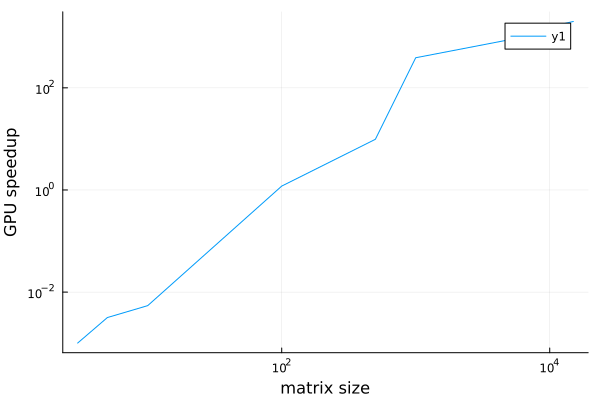

In [22]:
plot(mat_size,tcpu./tgpu, yaxis= :log, xaxis=:log, ylabel="GPU speedup", xlabel="matrix size")

### Example 2.2: Computing Custom Gradients on the GPU

In this example, we will consider the challenge of moving from a CPU-array-based implementation to a GPU-based-implementation. In [this paper](https://arxiv.org/pdf/2406.13191), we needed to efficiently compute the gradient of the following expression:

$\mathcal{L}=-\left\Vert c^{T}+\lambda^{T}A+\mu^{T}C\right\Vert _{1}+\lambda^{T}b+\mu^{T}d.$

with respect to the dual variables $\lambda$ and $\mu$. These gradients are given by
* $\frac{\partial\mathcal{L}}{\partial\lambda} =b-C{\rm sign}\left(c^{T}+\lambda^{T}A+\mu^{T}C\right)$
* $\frac{\partial\mathcal{L}}{\partial\mu} =d-A{\rm sign}\left(c^{T}+\lambda^{T}A+\mu^{T}C\right)$

Highly optimzied, non-allocating CPU code looks like the following:

In [24]:
function obj_gradient(lambda::Float64, mu::Vector{Float64}, grad_lambda::Float64, grad_mu::Vector{Float64}, A::Vector{Float64}, b::Vector{Float64}, C::Matrix{Float64}, d::Vector{Float64}, cg1::Vector{Float64}, ng::Int64, nl::Int64)
    grad_lambda  = copy(b[1])
    grad_mu     .= copy.(d)

    for el in 1:ng
        cv = @view C[:,el]
        s_gamma = Float64(sign(cg1[el] + lambda*A[el] + dot(mu, cv)))

        grad_lambda += -s_gamma*A[el]
        for jj = 1:2*nl
            grad_mu[jj] += -s_gamma*C[jj,el]
        end
    end

    return grad_lambda, grad_mu
end


obj_gradient (generic function with 1 method)

We can run this code with synthetic power system data, assuming 10,000 lines and 5,000 generators.

In [25]:
nl          = 10000
ng          = 5000
lambda      = 0.0
grad_lambda = 0.0
mu          = randn(2*nl)
grad_mu     = randn(2*nl)
A           = randn(ng)
b           = randn(1)
C           = randn(2*nl,ng)
d           = rand(2*nl)
cg1         = rand(ng)

cpu_gradient_time = @belapsed obj_gradient(lambda, mu, grad_lambda, grad_mu, A, b, C, d, cg1, ng, nl)

0.08992

However, this is **not efficient** with CuArrays! Why not? **Scalar indexing.** Generally, scalar indexing on GPUs is a bad idea. Recently, CUDA.jl has introduced ```UnifiedMemory```, where data accessed from the GPU device can be operated on via CPU with just ~2x latency, but this is for specialty applications.

In [26]:
x = CuArray(randn(10,10))
x[1,1]

ErrorException: Scalar indexing is disallowed.
Invocation of getindex resulted in scalar indexing of a GPU array.
This is typically caused by calling an iterating implementation of a method.
Such implementations *do not* execute on the GPU, but very slowly on the CPU,
and therefore should be avoided.

If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
to enable scalar iteration globally or for the operations in question.


In order to make this code efficient, we had to reformulate the gradient computation.

In [27]:
function obj_gradient_gpu_friendly(lambda::Float64, mu::CuVector{Float64}, grad_lambda::Float64, grad_mu::CuVector{Float64}, a::CuVector{Float64}, b::Vector{Float64}, c::CuMatrix{Float64}, d::CuVector{Float64}, cg1::CuVector{Float64}, sign_gamma::CuVector{Float64}, ng::Int64, nl::Int64, ct::CuMatrix{Float64})
    grad_lambda  = copy(b[1])
    # the next two lines do this: sign_gamma .= sign.(cg1 .+ lambda.*a .+ c'*mu)
    mul!(sign_gamma,ct,mu)
    sign_gamma  .= sign.(cg1 .+ lambda.*a .+ sign_gamma)
    grad_lambda -= dot(sign_gamma,a)
    mul!(grad_mu,c,sign_gamma)
    grad_mu .= .-grad_mu
    grad_mu .+= d

    return grad_lambda, grad_mu
end

obj_gradient_gpu_friendly (generic function with 1 method)

In [29]:
nl          = 10000
ng          = 5000
lambda      = 0.0
grad_lambda = 0.0
mu          = CuVector(randn(2*nl))
grad_mu     = CuVector(randn(2*nl))
A           = CuVector(randn(ng))
b           = randn(1)
C           = CuMatrix(randn(2*nl,ng))
Ct          = copy(C')
d           = CuVector(rand(2*nl))
cg1         = CuVector(rand(ng))
sign_gamma  = CuVector(zeros(ng))

gpu_gradient_time = @belapsed CUDA.@sync obj_gradient_gpu_friendly(lambda, mu, grad_lambda, grad_mu, A, b, C, d, cg1, sign_gamma, ng, nl, Ct)

0.0067429

In [31]:
println("Gradient computation speedup: ", cpu_gradient_time/gpu_gradient_time)

Gradient computation speedup: 13.33550846075131


* ```The main lesson here is this: performant Julia code, which was written with scalar indexing to avoid memory allocation or for the sake of readability/understandability, will often need to be reformulated to run efficiently on the GPU.```
* GPU arrays can be used to solve most of your problems, however, and should be used how typical abstract arrays are.

### Linear Algebra 

Before moving on, it is worth noting that CUDA has some awesome sparse, and non-sparse, linear system solver tools.
* ```CUBLAS.getrf_batched!``` will **batch** LU factorize dense matrices on the GPU in parallel (with or without pivoting)
* ```UBLAS.trsm_batched!``` will **batch** solve the resulting systems $Ly=b$; $Ux=y$
* example application is in our recent [paper](https://arxiv.org/pdf/2311.11833)
* Here is the LU solve function we wrote/used:

In [ ]:
function lu_solve!(A::Array{CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}, 1}, b::Array{CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}, 1})
    # solve Ax = LUx = b
    # 
    # stage 1: solve "Ly = b"
    side  = 'L'   # left side
    ul    = 'L'   # solve "L"
    tA    = 'N'   # not transposed
    dA    = 'U'   # assume all ones on diagonal!
    alpha = 1.0   # scalar
    CUBLAS.trsm_batched!(side, ul, tA, dA, alpha, A, b);

    # solve u
    ul    = 'U'  # solve "U"
    dA    = 'N'  # read diagonal
    CUBLAS.trsm_batched!(side, ul, tA, dA, alpha, A, b);
end

## Section 3. GPU Kernels ##

While CuArray and the CUDA linear algebra libraries are very convenient and quite fast, custom GPU kernels can be used to achieve faster speeds still. A GPU kernel is "a function that runs in parallel on a GPU". It isn't like a custom function, however, since it returns "nothing"; instead, it mutates the given inputs.

```function!(x,y) -> nothing```

If you launch your own Kernels, you get to **personally** manage the thread and block computations. Joy! This gives a high degree of computational granularity. Don't do this unless you are willing to invest the time in (1) writing good, safe code and (2) profiling against simpler methods to ensure there is actually a gain.

An excellent overview of GPU threads/blocks is given [here](https://cuda.juliagpu.org/stable/tutorials/introduction/). Essentially, the kernel uses a **trick** to determing its own computational payload. In summary, this trick is based on these funcitons:
1. ```threadIdx()``` calls the thread ID on a block
2. ```blockDim()``` returns the dimension of the block
3. ```blockIdx()``` returns the index of the block

These expression can be queried in 3 dimensions (x,y,z). Blocks are managed and executed by a "streaming multiprocessor" (SM).

![gpu](gpu.png)

This image comes from an overview of CUDA's [C/C++ library](https://developer.nvidia.com/blog/even-easier-introduction-cuda/). While Cu/GPU arrays are unique to the Julia API, block/thread management is a generic skill (useful in Julia or C/C++).

#### Note: when working with GPU kernels, scalar indexing (calling ```v[i]```) ~~is really bad~~ **is good and necessary!**

### Example 3.1: Simple Cuda Kernel

Let's assume we have $m$ quadratic systems, each of whose energy we can compute individually as $e_{i}=x_{i}^{T}A_{i}x_{i}$. We can compute these in parallel using GPU kernels. On the cpu, the code is pretty straightforward:

In [ ]:
function quadratic_computation_cpu!(A,x,e)
    for i in 1:length(e)
        e[i] = x[i]'*A[i]*x[i]
    end
end

quadratic_computation_cpu! (generic function with 1 method)

In [30]:
n_particles = 40*1024
n_states    = 10
A = [randn(n_states,n_states) for ii in 1:n_particles]
x = [randn(n_states) for ii in 1:n_particles]
e = [randn() for ii in 1:n_particles]

t_cpu = @belapsed quadratic_computation_cpu!(A,x,e)

0.0034071

We can now write a gpu kernel to accomplish the same task. Note: the kernel is launched by calling ```@cuda``` and then passing the optional keywords 
* ```threads```, to specify the number of threads that should launch, and
* ```blocks```, to specify the number of blocks

First, we define a kernel function. Note:
* it returns nothing
* it directly mutates the inputs
* it uses scalar indexing to access devise memory!

In [17]:
function quadratic_computation_gpu!(A,x,e,n_states)
    i = threadIdx().x
    for jj in 1:n_states # note -- row major!
        for ii in 1:n_states
            @inbounds e[i] += sum(x[ii,i]*A[ii,jj,i]*x[jj,i])
        end
    end
    return # returns nothing :)
end

quadratic_computation_gpu! (generic function with 1 method)

The **trick** is this: the tiny little thread only knows two things: its name (i.e., its index), and how to do some very basic math. It uses its name (i.e., its numerical index) to decide which math it should do.

Let's specify the number of threads we want to use, and then call the kernel!

In [19]:
n_particles = 40*1024
A = CuArray(randn(n_states,n_states,n_particles))
x = CuArray(randn(n_states,n_particles))
e = CuArray(randn(n_particles))

@belapsed @cuda threads=length(e) quadratic_computation_gpu!(A,x,e,n_states)

ErrorException: Number of threads in x-dimension exceeds device limit (40960 > 1024).

**OH NOOOO!** We tried to launch too many threads -- we only have 1024 on my GPU. We could either
1. 40x the amout of work each thread has to do, or
2. ask for additional blocks

Let's write both. Here is an updated function for option 1:

In [31]:
function quadratic_computation_gpu_overload!(A,x,e,n_states)
    i = threadIdx().x
    for jj in 1:n_states # note -- row major!
        for ii in 1:n_states
            for kk in 0:39
                @inbounds e[i + kk*1024] += sum(x[ii,i + kk*1024]*A[ii,jj,i + kk*1024]*x[jj,i + kk*1024])
            end
        end
    end
    return
end

quadratic_computation_gpu_overload! (generic function with 1 method)

In [32]:
n_particles = 40*1024
n_states    = 10
A = CuArray(randn(n_states,n_states,n_particles))
x = CuArray(randn(n_states,n_particles))
e = CuArray(randn(n_particles))

@belapsed CUDA.@sync @cuda threads=1024 quadratic_computation_gpu_overload!(A,x,e,n_states)

0.0069055

Not to good -- we didn't exploit parallelism very effectively, because we overloaded those poor threads.

Here is how we can apply option 2, where we deploy blocks with additional threads:

In [33]:
function quadratic_computation_gpu_blocks!(A,x,e,n_states)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    # if needed, we can also define a stride to loop over larger vectors -- not used here
    # stride = gridDim().x * blockDim().x

    @inbounds for ii in 1:n_states # note -- row major!
        @inbounds for jj in 1:n_states
            @inbounds e[index] += x[ii,index]*A[ii,jj,index]*x[jj,index]
        end
    end
    return
end

quadratic_computation_gpu_blocks! (generic function with 1 method)

In [ ]:
n_particles = 40*1024
n_states    = 10
numblocks   = 40
A = CuArray(randn(n_states,n_states,n_particles))
x = CuArray(randn(n_states,n_particles))
e = CuArray(randn(n_particles))

t_gpu = @belapsed CUDA.@sync @cuda threads=1024 blocks=numblocks quadratic_computation_gpu_blocks!(A,x,e,n_states)

0.000408

Now, we are at least 50% faster than the CPU, but we can be much faster still if we exploit multi-dimensional multithreading (x,y,z).

## Non-CUDA kernels
For non-CUDA kernels, Julia has [KernelAbstractions.jl](https://juliagpu.github.io/KernelAbstractions.jl/stable/examples/matmul/). Here is an [excellent video](https://www.youtube.com/watch?v=1Q5Hpwu3tpo&t=3590s), too.

### Example 3.2: An ADMM example

Many of us are familiar with ADMM, a distributed optimization technique which iteratively minimizes a set of distributed primal objectives, takes a dual ascent step, and continues on. In a [recent paper](https://arxiv.org/pdf/2310.09410) by Ryu et al., they solve the following problem over $|S|$ subsystems:

![s](.\figs\admm.png)

They forumularte a Lagrange dual, and then apply stationarity conditions to explictly compute a solution for the primal as a function of the duals:

![s](.\figs\admm_soln.png)

The update algorithm is given below:
![s](.\figs\alg.png)
Given the following primal and dual update rules, **can you write a kernel?**

And now here is the CPU code:

In [ ]:
nS     = 100 # number of systems
nv     = 50  # number of variables
C      = randn(nv)
x      = [randn(nv)    for S in 1:nS]
lambda = [randn(nv)    for S in 1:nS]
xhat   = [randn(nv)    for S in 1:nS]
B      = [randn(nv,nv) for S in 1:nS]
xupper = [10*rand(nv)  for S in 1:nS]
xlower = [-10*rand(nv) for S in 1:nS]

for S in 1:nS

    # x update
    xhat[S] = (-1)*(C + sum(B[S]'*lambda[S] for S in 1:nS) - sum(x')')
    x[S] = min.( max.(xhat[S], xlower[S]), xupper[S])
    
    # update lambda
    lambda[S] = lambda[S] + p*(B[S]*x[S]-x[S])
end

In [ ]:
function admm_kernel(C, x, xhat, lambda, xupper, xlower)

    return: nothing
end

# call the kernel!

@cude threads blocks admm_kernel